### Install

In [ ]:
!pip install mediapipe face-alignment

In [ ]:
!mkdir checkpoints

mkdir: cannot create directory ‘checkpoints’: File exists


In [ ]:
!wget -O checkpoints/detector.tflite https://storage.googleapis.com/mediapipe-models/face_detector/blaze_face_short_range/float16/1/blaze_face_short_range.tflite

--2024-11-02 11:35:26--  https://storage.googleapis.com/mediapipe-models/face_detector/blaze_face_short_range/float16/1/blaze_face_short_range.tflite
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.12.207, 172.217.194.207, 142.250.4.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.12.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 229746 (224K) [application/octet-stream]
Saving to: ‘checkpoints/detector.tflite’

checkpoints/detecto 100%[===================>] 224.36K   398KB/s    in 0.6s    

2024-11-02 11:35:26 (398 KB/s) - ‘checkpoints/detector.tflite’ saved [229746/229746]



In [ ]:
!gdown -O checkpoints/ 1wFkGXI36lZZQpOeIuM_0BxX2rIYSIA1K

Downloading...
From (original): https://drive.google.com/uc?id=1wFkGXI36lZZQpOeIuM_0BxX2rIYSIA1K
From (redirected): https://drive.google.com/uc?id=1wFkGXI36lZZQpOeIuM_0BxX2rIYSIA1K&confirm=t&uuid=deb598f8-ed64-4ff1-87c2-c57d5e326275
To: /content/checkpoints/arcface.pt
100% 261M/261M [00:02<00:00, 109MB/s] 


In [ ]:
!gdown -O checkpoints/ 1FSCUC5CbyPKnl5Bbt58tPcKCVOyyt004

Downloading...
From (original): https://drive.google.com/uc?id=1FSCUC5CbyPKnl5Bbt58tPcKCVOyyt004
From (redirected): https://drive.google.com/uc?id=1FSCUC5CbyPKnl5Bbt58tPcKCVOyyt004&confirm=t&uuid=00dd4c68-85cd-4fa9-b141-1ef6987f2d77
To: /content/checkpoints/blendface.pt
100% 261M/261M [00:04<00:00, 55.6MB/s]


In [ ]:
!gdown -O checkpoints/ 1ssTKnNVGomtrtPl57EOGzKNz62bh6mSs

Downloading...
From (original): https://drive.google.com/uc?id=1ssTKnNVGomtrtPl57EOGzKNz62bh6mSs
From (redirected): https://drive.google.com/uc?id=1ssTKnNVGomtrtPl57EOGzKNz62bh6mSs&confirm=t&uuid=fbd816ae-4b73-4f99-b1c7-de9408c1ee0a
To: /content/checkpoints/blendswap.pth
100% 3.06G/3.06G [01:00<00:00, 50.8MB/s]


In [ ]:
!mkdir samples

mkdir: cannot create directory ‘samples’: File exists


In [ ]:
!gdown -O samples/ 1LrgW4cub4a198xpLlz9CWfER4xkWou_9

Downloading...
From: https://drive.google.com/uc?id=1LrgW4cub4a198xpLlz9CWfER4xkWou_9
To: /content/samples/sample_1.jpg
100% 1.21M/1.21M [00:00<00:00, 114MB/s]


In [ ]:
!gdown -O samples/ 1D-hDxc2KILOccV7ZlSubzi_fUilT_U8d

Downloading...
From: https://drive.google.com/uc?id=1D-hDxc2KILOccV7ZlSubzi_fUilT_U8d
To: /content/samples/sample_2.jpg
100% 1.44M/1.44M [00:00<00:00, 110MB/s]


In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
!git clone https://github.com/mapooon/BlendFace.git

fatal: destination path 'BlendFace' already exists and is not an empty directory.


In [ ]:
import sys
import numpy as np
import PIL
import scipy
from pathlib import Path
import cv2
import torch
import numpy as np
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
from mediapipe.tasks.python.components.containers.detections import DetectionResult
from PIL import Image
import face_alignment
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

Bbox = np.ndarray

### Do not modify

In [ ]:
def image_align_68(img, face_landmarks, output_size=256, transform_size=1024, enable_padding=True):
    # Align function from FFHQ dataset pre-processing step
    # https://github.com/NVlabs/ffhq-dataset/blob/master/download_ffhq.py

    lm = np.array(face_landmarks)
    lm_chin          = lm[0  : 17, :2]  # left-right
    lm_eyebrow_left  = lm[17 : 22, :2]  # left-right
    lm_eyebrow_right = lm[22 : 27, :2]  # left-right
    lm_nose          = lm[27 : 31, :2]  # top-down
    lm_nostrils      = lm[31 : 36, :2]  # top-down
    lm_eye_left      = lm[36 : 42, :2]  # left-clockwise
    lm_eye_right     = lm[42 : 48, :2]  # left-clockwise
    lm_mouth_outer   = lm[48 : 60, :2]  # left-clockwise
    lm_mouth_inner   = lm[60 : 68, :2]  # left-clockwise

    # Calculate auxiliary vectors.
    eye_left     = np.mean(lm_eye_left, axis=0)
    eye_right    = np.mean(lm_eye_right, axis=0)
    eye_avg      = (eye_left + eye_right) * 0.5
    eye_to_eye   = eye_right - eye_left
    mouth_left   = lm_mouth_outer[0]
    mouth_right  = lm_mouth_outer[6]
    mouth_avg    = (mouth_left + mouth_right) * 0.5
    eye_to_mouth = mouth_avg - eye_avg

    # Choose oriented crop rectangle.
    x = eye_to_eye - np.flipud(eye_to_mouth) * [-1, 1]
    x /= np.hypot(*x)
    x *= max(np.hypot(*eye_to_eye) * 2.0, np.hypot(*eye_to_mouth) * 1.8)
    y = np.flipud(x) * [-1, 1]
    c = eye_avg + eye_to_mouth * 0.1
    quad = np.stack([c - x - y, c - x + y, c + x + y, c + x - y])
    qsize = np.hypot(*x) * 2

    # Load in-the-wild image.
    if isinstance(img, np.ndarray):
      img = PIL.Image.fromarray(img)

    # Shrink.
    shrink = int(np.floor(qsize / output_size * 0.5))
    if shrink > 1:
        rsize = (int(np.rint(float(img.size[0]) / shrink)), int(np.rint(float(img.size[1]) / shrink)))
        img = img.resize(rsize, PIL.Image.LANCZOS)
        quad /= shrink
        qsize /= shrink

    # Crop.
    border = max(int(np.rint(qsize * 0.1)), 3)
    crop = (int(np.floor(min(quad[:,0]))), int(np.floor(min(quad[:,1]))), int(np.ceil(max(quad[:,0]))), int(np.ceil(max(quad[:,1]))))
    crop = (max(crop[0] - border, 0), max(crop[1] - border, 0), min(crop[2] + border, img.size[0]), min(crop[3] + border, img.size[1]))
    if crop[2] - crop[0] < img.size[0] or crop[3] - crop[1] < img.size[1]:
        img = crop_image(np.array(img), crop)
        if isinstance(img, np.ndarray):
          img = PIL.Image.fromarray(img)
        quad -= crop[0:2]

    # Pad.
    pad = (int(np.floor(min(quad[:,0]))), int(np.floor(min(quad[:,1]))), int(np.ceil(max(quad[:,0]))), int(np.ceil(max(quad[:,1]))))
    pad = (max(-pad[0] + border, 0), max(-pad[1] + border, 0), max(pad[2] - img.size[0] + border, 0), max(pad[3] - img.size[1] + border, 0))
    if enable_padding and max(pad) > border - 4:
        pad = np.maximum(pad, int(np.rint(qsize * 0.3)))
        img = np.pad(np.float32(img), ((pad[1], pad[3]), (pad[0], pad[2]), (0, 0)), 'reflect')
        h, w, _ = img.shape
        y, x, _ = np.ogrid[:h, :w, :1]
        mask = np.maximum(1.0 - np.minimum(np.float32(x) / pad[0], np.float32(w-1-x) / pad[2]), 1.0 - np.minimum(np.float32(y) / pad[1], np.float32(h-1-y) / pad[3]))
        blur = qsize * 0.02
        img += (scipy.ndimage.gaussian_filter(img, [blur, blur, 0]) - img) * np.clip(mask * 3.0 + 1.0, 0.0, 1.0)
        img += (np.median(img, axis=(0,1)) - img) * np.clip(mask, 0.0, 1.0)
        img = PIL.Image.fromarray(np.uint8(np.clip(np.rint(img), 0, 255)), 'RGB')
        quad += pad[:2]

    # Transform.
    img = img.transform((transform_size, transform_size), PIL.Image.QUAD, (quad + 0.5).flatten(), PIL.Image.BILINEAR)
    if output_size < transform_size:
        img = img.resize((output_size, output_size), PIL.Image.LANCZOS)

    # return aligned image.
    return img

In [ ]:
def align_faces(img: np.ndarray, landmarks: list):
    aligned_faces = []
    for face_landmarks in landmarks:
        aligned_face = image_align_68(img, face_landmarks)
        aligned_faces.append(aligned_face)

    # return only one face
    return aligned_faces[0]

In [ ]:
def detect_faces(img: np.ndarray):
    # STEP 1: Import the necessary modules.
    ## Done in global import

    # STEP 2: Create an FaceDetector object.
    base_options = python.BaseOptions(model_asset_path='checkpoints/detector.tflite')
    options = vision.FaceDetectorOptions(base_options=base_options)
    detector = vision.FaceDetector.create_from_options(options)

    # STEP 3: Load the input image.
    rgb_img = mp.Image(image_format=mp.ImageFormat.SRGB, data=img)

    # STEP 4: Detect faces in the input image.
    detection_result = detector.detect(rgb_img)

    return detection_result


In [ ]:
def get_bounding_bboxes(face_detection_result: DetectionResult, width:int, height: int, factor: int):
    list_bbox = []
    for result in face_detection_result.detections:
        x,y,w,h = get_expanded_bbox(result, width, height, factor)
        x1,y1,x2,y2 = bbox_xywh_to_xyxy(x,y,w,h)
        bbox = np.array([x1,y1,x2,y2])
        list_bbox.append(bbox)
    return list_bbox

In [ ]:
def load_image(image_path: str):
    """
    Input : image_path : str
    Retrun: numpy array of the image
    """
    # TODO load and return the image with cv2
    img=cv2.imread(image_path)
    img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    return img


### TODO

In [ ]:
def load_image(image_path: str):
    """
    Input : image_path : str
    Retrun: numpy array of the image
    """
    # TODO load and return the image with cv2
    # raise NotImplementedError("TODO")
    img=cv2.imread(image_path)
    img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    return img

    #breakpoint()

    # end TODO

def get_expanded_bbox(face_detection: DetectionResult, width: int, height: int, factor: float = 1.0):
    """
    Input : face_detection_list: DetectionResult
    Retrun: x,y,w,h of the expanded bounding boxes
    """
    bbox = face_detection.bounding_box
    x_min = bbox.origin_x
    y_min = bbox.origin_y
    box_width = bbox.width
    box_height = bbox.height

    # Calculer le centre de la boîte englobante
    x_center = x_min + box_width / 2
    y_center = y_min + box_height / 2

    # Appliquer le facteur d'expansion à la largeur et à la hauteur
    new_width = box_width * factor
    new_height = box_height * factor

    # Calculer les nouvelles coordonnées de la boîte englobante agrandie
    new_x_min = x_center - new_width / 2
    new_y_min = y_center - new_height / 2

    # S'assurer que la boîte reste dans les limites de l'image
    new_x_min = max(0, new_x_min)
    new_y_min = max(0, new_y_min)
    new_width = min(width - new_x_min, new_width)
    new_height = min(height - new_y_min, new_height)

    # Retourner les nouvelles coordonnées de la boîte englobante (x, y, largeur, hauteur)
    return int(new_x_min), int(new_y_min), int(new_width), int(new_height)

def bbox_xywh_to_xyxy(x,y,w,h):
    """
    Input : x,y,w,h of the bounding boxes
    Retrun: x1,y1,x2,y2 of the bounding boxes
    """


    x1=x
    y1=y
    x2=x+w
    y2=y+h


    # TODO transform a xywh bbox into a x1 y1, x2, y2 bbox
    # return the new bbox
    #
    #    (x1,y1)____________
    #        |              |
    #        |              |
    #        |              |
    #        |__________ (x2,y2)
    #
    return x1,x2,y1,y2



    #end TODO

def show_bbox(img: np.ndarray, list_bbox: list[Bbox]):
    """
    Input : img and list of bounding boxes
    Return: None
    """
    for (x1, y1, x2, y2) in list_bbox:
        cv2.rectangle(img, (int(x1), int(y1)), (int(x2), int(y2)), (255, 0, 0), 2)
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    return






def crop_image(img: np.ndarray, crop):
    """
    Input : img and crop bounding box
    Return: cropped image in ndarray format
    """

    x1,y1,x2,y2 = crop
    cropped_img = img[int(y1):int(y2), int(x1):int(x2)]
    return cropped_img


def get_face_swap_model(weight_path: str, device: str):
    sys.path.insert(0, './BlendFace/swapping')
    from blendswap import BlendSwap
    import torch

    # TODO Create model
    ## Instanciate the model BlendSwap
    ## load the checkpoint
    ## set the model to eval mode
    ## Send model to device
    model = BlendSwap().to(device)
    checkpoint = torch.load(weight_path, map_location=device)
    model.load_state_dict(checkpoint)
    model.eval()
    return model

def transform_input(image: Image, device: str, shape: tuple[int]) -> torch.tensor:
    from torchvision import transforms
    to_tensor = transforms.ToTensor()

    # TODO
    ## convert to rgb format (remove alpha channel)
    ## resize to requested shape
    ## transform to tensor with to_tensor()
    ## unsqueeze first dimention to have batch size of one
    ## send to device
    ### (all of this can be made in a single line)


    image = image.convert('RGB').resize(shape)
    tensor = to_tensor(image).unsqueeze(0).to(device)
    return tensor


def insert_src_img_into_dst_img(face: Image, source_img: Image):
    weight_path  = 'checkpoints/blendswap.pth'
    model = get_face_swap_model(weight_path=weight_path, device=DEVICE)

    source_img = transform_input(source_img, device=DEVICE, shape=(112,112))
    original_height, original_width = face.size

    target_img = transform_input(face, device=DEVICE, shape=(256,256))

    # TODO infer the model
    ## In a torch.no_gard context infer the model
    ## the first  parameter is target_img
    ## the second parameter is source_img
    ## store the result in a output variable
    with torch.no_grad():
        output = model(target_img, source_img)


    swapped_face = Image.fromarray((output.permute(0,2,3,1)[0].cpu().data.numpy()*255).astype(np.uint8))
    swapped_face.resize((original_width, original_height))

    return swapped_face

def show_3d_landmarks(landmarks: np.ndarray):
    # TODO visualize 3d landmark in matplot lib
    ## import package
    ## create figure
    ## display figure
    from mpl_toolkits.mplot3d import Axes3D
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(landmarks[:, 0], landmarks[:, 1], landmarks[:, 2])
    plt.show()

    return

def show_faces(faces: list[Image]):
    # TODO show the 3 faces using plt
    ## you will need to transform the image back to ndarray
    ## use the imshow function of plt
    fig, axes = plt.subplots(1, len(faces), figsize=(15, 5))
    for ax, face in zip(axes, faces):
        ax.imshow(np.array(face))
        ax.axis('off')
    plt.show()

def get_arcface_model(device : str = 'cpu'):
    sys.path.insert(0, './BlendFace')
    from iresnet import iresnet100 as Arcface
    arcface = Arcface(pretrained=False, fp16=False)

    # TODO load the weight (arcface.pt), send to device, and set mode to eval, and return the model
    checkpoint = torch.load('checkpoints/arcface.pt', map_location=device)
    arcface.load_state_dict(checkpoint)
    arcface.to(device)
    arcface.eval()
    return arcface

def compare_similarity(img_source: Image, img_dst: Image, img_swapped: Image):
    arcface = get_arcface_model(DEVICE)

    img_source = np.array(img_source.resize((112,112)))
    img_dst = np.array(img_dst.resize((112,112)))
    img_swapped = np.array(img_swapped.resize((112,112)))
    img_source=torch.tensor(img_source).to(DEVICE).permute(2,0,1).unsqueeze(0)/255
    img_dst=torch.tensor(img_dst).to(DEVICE).permute(2,0,1).unsqueeze(0)/255
    img_swapped=torch.tensor(img_swapped).to(DEVICE).permute(2,0,1).unsqueeze(0)/255
    img_source=(img_source-0.5)/0.5
    img_dst=(img_dst-0.5)/0.5
    img_swapped=(img_swapped-0.5)/0.5
    vec_src=arcface(img_source)
    vec_dst=arcface(img_dst)
    vec_swapped=arcface(img_swapped)

    import torch.nn as nn
    # TODO use one of the similarity metric in the question to compare the pair (vec_src, vec_dst) and (vec_src, vec_swapped)
    ## print the result, what do you think about the similarity ?
    ## you can also try a different metric
    cosine_similarity = torch.nn.functional.cosine_similarity(vec_src, vec_dst)
    cosine_similarity_swapped = torch.nn.functional.cosine_similarity(vec_src, vec_swapped)
    print("Similitude avec originale :", cosine_similarity.item())
    print("Similitude avec visage swap :", cosine_similarity_swapped.item())

class TP:
    def __init__(self):
        self.img_dst_path = 'samples/sample_1.jpg'
        self.img_src_path = 'samples/sample_2.jpg'
        self.bounding_box_factor = 1.2
        self.fa = face_alignment.FaceAlignment(face_alignment.LandmarksType.THREE_D, flip_input=False, device=DEVICE, face_detector='blazeface')

    def load_and_align_source_image(self):
        # TODO using all the previous steps we implemented load and align the source image and return it as a PIL image
        ## Load the image from the self.img_src_path
        img_src = load_image(self.img_src_path)
        landmarks = self.fa.get_landmarks(img_src)
        aligned_face = align_faces(img_src, landmarks)
        if isinstance(aligned_face, Image.Image):
           return aligned_face  # Return directly if it's already an Image
        else:
           return Image.fromarray(aligned_face)  # Convert to Image if it's a NumPy array

    def main(self, vis_aligned_face = False, vis_3d_landmarks=False, vis_2d_bbox=False):
        img_dst = load_image(self.img_dst_path)
        height, width = img_dst.shape[:2]

        ## Detect Faces
        face_detection_result = detect_faces(img_dst)

        ## Get Bbox
        list_bbox = get_bounding_bboxes(face_detection_result, width, height, factor=self.bounding_box_factor)

        if vis_2d_bbox:
            ## Viz bbox on frame
            show_bbox(img_dst.copy(), list_bbox)

        ## Get 3d landmarks
        landmarks = self.fa.get_landmarks(img_dst)

        # Align faces
        aligned_face = align_faces(img_dst, landmarks)

        if vis_aligned_face:
            plt.imshow(aligned_face)
            plt.show()

        if vis_3d_landmarks:
            show_3d_landmarks(landmarks[0])

        ## Swap faces
        img_src =  self.load_and_align_source_image()
        swapped_face = insert_src_img_into_dst_img(aligned_face, img_src)

        show_faces([img_src, aligned_face, swapped_face])

        compare_similarity(
            img_src,
            aligned_face,
            swapped_face,
        )

In [ ]:
DEVICE = 'cpu' # do not use GPU

<ipython-input-42-2191d6a6c319>:116: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(weight_path, map_location=device)


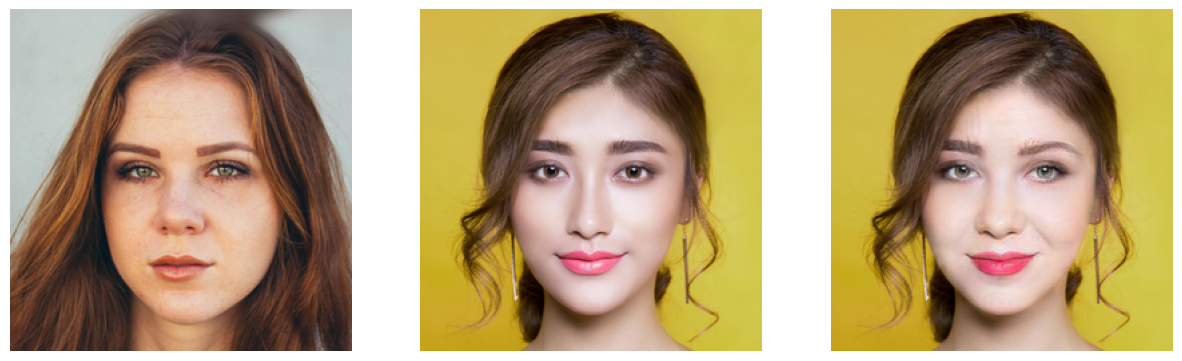

<ipython-input-42-2191d6a6c319>:191: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('checkpoints/arcface.pt', map_location=device)


Similitude originale : -0.032254308462142944
Similitude avec visage swap : 0.6256026029586792


In [ ]:
TP().main(vis_2d_bbox=False, vis_aligned_face=False, vis_3d_landmarks=False)

# [5 pts]() Part 2. Instructions

For this almost not guided part, we will be using the [EG3D](https://nvlabs.github.io/eg3d/) model from Nvidia, first read at least the abstract of the paper.
You are asked to generate a short video that transitions a face from one identity to another, the transition isn't required to be super smooth as it is cumputatinally intensive. Provide a step-by-step explanation of how you did it.

**hint** : you will need to get the latent space point of an identity and then reach the other identity by travel across the latent space. There is multiple way of doing it, but one way starts by using the `project` function which makes a simple inversion (there are other advanced inversion technique like PTI) that give you one latent space point for one identity.

To help you use that function and load the model look into the `FaceDNeRF/run_projector.py` script.

for this part you will need GPU acceleration, use T4 free tier.

We provide all the needed install and import

You have some test data in the `FaceDNeRF/test_data` folder

the CWD is already `FaceDNeRF`

## Install

In [69]:
%cd /content


/content


In [70]:
!git clone https://github.com/BillyXYB/FaceDNeRF.git
%cd FaceDNeRF
!wget --content-disposition 'https://api.ngc.nvidia.com/v2/models/org/nvidia/team/research/eg3d/1/files?redirect=true&path=ffhqrebalanced512-128.pkl' -O /content/FaceDNeRF/networks/ffhqrebalanced512-128.pkl
!wget https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/metrics/vgg16.pt -O /content/FaceDNeRF/networks/vgg16.pt
!gdown -O /content/FaceDNeRF/networks/model_ir_se50.pth 1KW7bjndL3QG3sxBbZxreGHigcCCpsDgn

Cloning into 'FaceDNeRF'...
remote: Enumerating objects: 218, done.
remote: Counting objects: 100% (218/218), done.
remote: Compressing objects: 100% (163/163), done.
remote: Total 218 (delta 71), reused 196 (delta 53), pack-reused 0 (from 0)
Receiving objects: 100% (218/218), 7.99 MiB | 5.81 MiB/s, done.
Resolving deltas: 100% (71/71), done.
/content/FaceDNeRF
--2024-11-03 14:42:25--  https://api.ngc.nvidia.com/v2/models/org/nvidia/team/research/eg3d/1/files?redirect=true&path=ffhqrebalanced512-128.pkl
Resolving api.ngc.nvidia.com (api.ngc.nvidia.com)... 54.200.66.240, 44.237.84.50
Connecting to api.ngc.nvidia.com (api.ngc.nvidia.com)|54.200.66.240|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://xfiles.ngc.nvidia.com/org/nvidia/team/research/models/eg3d/versions/1/files/ffhqrebalanced512-128.pkl?versionId=YyNd4OafnIxsU8cnrQhZYXcu73UNNqYv&Expires=1730731345&Signature=bgpBZuS~CsqVqak0xzML4DPqrNbx04WKNvcAaCNvG3lLMju8kAADeWu1pMEHn5ki7wpTuRh9Sq3Chyve2

In [71]:
!pip install kornia
!pip install ninja
!pip install mrcfile
!pip install diffusers["torch"] transformers

## TODO

In [72]:
import sys
sys.path.append('DPR_model')
sys.path.append('DPR_utils')

import torch
torch.autograd.set_detect_anomaly(True)
import torch.nn.functional as F
from torch import nn
import torchvision
from torchvision.transforms import transforms
import os
import re
from typing import List, Optional, Tuple, Union
import pickle
import dnnlib
import numpy as np
import legacy
import PIL
from PIL import Image
import cv2
import copy
from tqdm import tqdm
from camera_utils import LookAtPoseSampler

In [73]:
device = 'cuda'

In [74]:
def project(
        G,
        c,
        outdir,
        target: torch.Tensor,  # [C,H,W] and dynamic range [0,255], W & H must match G output resolution
        *,
        num_steps=1000,
        w_avg_samples=10000,
        initial_learning_rate=0.01,
        initial_noise_factor=0.05,
        lr_rampdown_length=0.25,
        lr_rampup_length=0.05,
        noise_ramp_length=0.75,
        regularize_noise_weight=1e5,
        verbose=False,
        device: torch.device,
        initial_w=None,
        image_log_step=100,
        w_name: str
):
    os.makedirs(f'{outdir}/{w_name}_w', exist_ok=True)
    outdir = f'{outdir}/{w_name}_w'
    assert target.shape == (G.img_channels, G.img_resolution, G.img_resolution)

    G = copy.deepcopy(G).eval().requires_grad_(False).to(device).float() # type: ignore

    print(f'Computing W midpoint and stddev using {w_avg_samples} samples...')
    z_samples = np.random.RandomState(123).randn(w_avg_samples, G.z_dim)

    # use avg look at point
    camera_lookat_point = torch.tensor(G.rendering_kwargs['avg_camera_pivot'], device=device)
    cam2world_pose = LookAtPoseSampler.sample(3.14 / 2, 3.14 / 2, camera_lookat_point,
                                              radius=G.rendering_kwargs['avg_camera_radius'], device=device)
    focal_length = 4.2647  # FFHQ's FOV
    intrinsics = torch.tensor([[focal_length, 0, 0.5], [0, focal_length, 0.5], [0, 0, 1]], device=device)
    c_samples = torch.cat([cam2world_pose.reshape(-1, 16), intrinsics.reshape(-1, 9)], 1)
    c_samples = c_samples.repeat(w_avg_samples, 1)

    w_samples = G.mapping(torch.from_numpy(z_samples).to(device), c_samples)  # [N, L, C]
    w_samples = w_samples[:, :1, :].cpu().numpy().astype(np.float32)  # [N, 1, C]
    w_avg = np.mean(w_samples, axis=0, keepdims=True)  # [1, 1, C]
    w_avg_tensor = torch.from_numpy(w_avg).cuda()
    w_std = (np.sum((w_samples - w_avg) ** 2) / w_avg_samples) ** 0.5

    start_w = initial_w if initial_w is not None else w_avg

    # Setup noise inputs.
    noise_bufs = {name: buf for (name, buf) in G.backbone.synthesis.named_buffers() if 'noise_const' in name}

    # Load VGG16 feature detector.
    #url = 'https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/metrics/vgg16.pt'
    url = './networks/vgg16.pt'
    with dnnlib.util.open_url(url) as f:
        vgg16 = torch.jit.load(f).eval().to(device)

    # Features for target image.
    target_images = target.unsqueeze(0).to(device).to(torch.float32)
    if target_images.shape[2] > 256:
        target_images = F.interpolate(target_images, size=(256, 256), mode='area')
    target_features = vgg16(target_images, resize_images=False, return_lpips=True)

    start_w = np.repeat(start_w, G.backbone.mapping.num_ws, axis=1)
    w_opt = torch.tensor(start_w, dtype=torch.float32, device=device,
                         requires_grad=True)  # pylint: disable=not-callable

    optimizer = torch.optim.Adam([w_opt] + list(noise_bufs.values()), betas=(0.9, 0.999),
                                 lr=0.1)

    # Init noise.
    for buf in noise_bufs.values():
        buf[:] = torch.randn_like(buf)
        buf.requires_grad = True

    for step in tqdm(range(num_steps)):

        # Learning rate schedule.
        t = step / num_steps
        w_noise_scale = w_std * initial_noise_factor * max(0.0, 1.0 - t / noise_ramp_length) ** 2
        lr_ramp = min(1.0, (1.0 - t) / lr_rampdown_length)
        lr_ramp = 0.5 - 0.5 * np.cos(lr_ramp * np.pi)
        lr_ramp = lr_ramp * min(1.0, t / lr_rampup_length)
        lr = initial_learning_rate * lr_ramp
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

        # Synth images from opt_w.
        w_noise = torch.randn_like(w_opt) * w_noise_scale
        ws = (w_opt + w_noise)
        synth_images = G.synthesis(ws,c, noise_mode='const')['image']

        if step % image_log_step == 0:
            with torch.no_grad():
                vis_img = (synth_images.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)

                PIL.Image.fromarray(vis_img[0].cpu().numpy(), 'RGB').save(f'{outdir}/{step}.png')

        # Downsample image to 256x256 if it's larger than that. VGG was built for 224x224 images.
        synth_images = (synth_images + 1) * (255 / 2)
        if synth_images.shape[2] > 256:
            synth_images = F.interpolate(synth_images, size=(256, 256), mode='area')

        # Features for synth images.
        synth_features = vgg16(synth_images, resize_images=False, return_lpips=True)
        dist = (target_features - synth_features).square().sum()

        # Noise regularization.
        reg_loss = 0.0
        for v in noise_bufs.values():
            noise = v[None, None, :, :]  # must be [1,1,H,W] for F.avg_pool2d()
            while True:
                reg_loss += (noise * torch.roll(noise, shifts=1, dims=3)).mean() ** 2
                reg_loss += (noise * torch.roll(noise, shifts=1, dims=2)).mean() ** 2
                if noise.shape[2] <= 8:
                    break
                noise = F.avg_pool2d(noise, kernel_size=2)
        loss = dist + reg_loss * regularize_noise_weight

        # Step
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

        # Normalize noise.
        with torch.no_grad():
            for buf in noise_bufs.values():
                buf -= buf.mean()
                buf *= buf.square().mean().rsqrt()

    del G
    return w_opt

In [75]:
def get_generator(network_pkl: str ="networks/ffhqrebalanced512-128.pkl", sampling_multiplier= 2, device='cuda'):
  with dnnlib.util.open_url(network_pkl) as f:
    G = legacy.load_network_pkl(f)['G_ema'].to(device)  # type: ignore

  G.rendering_kwargs['depth_resolution'] = int(G.rendering_kwargs['depth_resolution'] * sampling_multiplier)
  G.rendering_kwargs['depth_resolution_importance'] = int(
    G.rendering_kwargs['depth_resolution_importance'] * sampling_multiplier
  )
  return G

def get_image_and_c(image_path, c_path):
  image = Image.open(image_path).convert('RGB')
  image_name = os.path.basename(image_path)[:-4]
  c = np.load(c_path)
  c = np.reshape(c,(1,25))

  c = torch.FloatTensor(c).cuda()

  trans = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
      transforms.Resize((512,512))
  ])
  from_im = trans(image).cuda()
  image = torch.squeeze((from_im.cuda() + 1) / 2) * 255

  return image, c

def get_latent(G, image_path, c_path, num_steps, w_avg_samples):
  outdir = 'out'
  device = torch.device('cuda')
  img, c = get_image_and_c(image_path, c_path)

  w = project(G, c, outdir, img, device=torch.device('cuda'), w_avg_samples=w_avg_samples,num_steps = num_steps, w_name=os.path.basename(image_path)[:-4])

  return w


In [76]:
G=get_generator(device=device)

In [77]:
print(G)

TriPlaneGenerator(
  (renderer): ImportanceRenderer(
    (ray_marcher): MipRayMarcher2()
  )
  (ray_sampler): RaySampler()
  (backbone): Generator(
    (synthesis): SynthesisNetwork(
      w_dim=512, num_ws=14, img_resolution=256, img_channels=96, num_fp16_res=0
      (b4): SynthesisBlock(
        resolution=4, architecture=skip
        (conv1): SynthesisLayer(
          in_channels=512, out_channels=512, w_dim=512, resolution=4, up=1, activation=lrelu
          (affine): FullyConnectedLayer(in_features=512, out_features=512, activation=linear)
        )
        (torgb): ToRGBLayer(
          in_channels=512, out_channels=96, w_dim=512
          (affine): FullyConnectedLayer(in_features=512, out_features=512, activation=linear)
        )
      )
      (b8): SynthesisBlock(
        resolution=8, architecture=skip
        (conv0): SynthesisLayer(
          in_channels=512, out_channels=512, w_dim=512, resolution=8, up=2, activation=lrelu
          (affine): FullyConnectedLayer(in_feature